# Libraries and definitions

In [1]:
import pandas as pd
import numpy as np
from os.path import join
from matplotlib import pyplot as plt
from xgboost import XGBClassifier

In [2]:
DATA_DIR = 'data'
DATA_FILE = join(DATA_DIR,'covid_data_2.csv')

In [3]:
REF_DATE = pd.to_datetime('2022-01-01')
SCALE = False#True
APPLY_PCA = False
DATA_TYPE = 2
FILTER_MI = True

# Preprocess data

## Filter data

In [4]:
def filter_data_date(data,reference_date = REF_DATE):
    '''For each person (record_id), get only the row with the visit date closest to reference_date'''
    data['visit_date'] = pd.to_datetime(data['visit_date'])
    data = data.dropna(subset=['visit_date'],ignore_index = True)
    data = data[data['visit_date'] < reference_date]
    return data.sort_values(by=['record_id','visit_date'],ascending = [True,False]).drop_duplicates(subset=['record_id'], keep='first')#.reset_index()


In [5]:
all_data = pd.read_csv(DATA_FILE)
raw_data = filter_data_date(all_data).dropna(axis=1, how='all') #apply date filter and remove empty columns
raw_data.pop('visit_date')
#raw_data.pop('index_date')
raw_data.set_index('record_id',inplace=True)
assert (all_data['record_id'].unique() == raw_data.index).all()

In [6]:
raw_data

,Unnamed: 0,final_outcome_amp,timepoint,study,pop_sample,index_date,age,sex,bmi,smoking,...,last_antibody_before_omicron_igg_s_logratio,last_antibody_before_omicron_iga_log10ratio,last_antibody_before_omicron_igg_n_log10ratio,last_antibody_before_omicron_igg_s_log10ratio,last_antibody_before_omicron_iga_ratio,last_antibody_before_omicron_igg_n_ratio,last_antibody_before_omicron_igg_s_ratio,prior_hyg,prior_dist,prior_mask_mand
record_id,,,,,,,,,,,,,,,,,,,,,
1,4,1,M12,ZSAC,prospective,2020-08-06,23,female,24.618104,Non-smoker,...,3.887730,0.416300,0.000000,1.688420,2.607955,1.0,48.8,7.0,2.0,7.0
2,11,1,M12,ZSAC,prospective,2020-08-06,51,male,26.643599,Ex-smoker,...,3.772761,0.547579,0.000000,1.638489,3.528409,1.0,43.5,7.0,6.0,7.0
3,18,1,M12,ZSAC,prospective,2020-08-06,36,male,23.190497,Non-smoker,...,4.409155,1.654363,0.000000,1.914872,45.119318,1.0,82.2,7.0,5.0,7.0
5,25,0,M12,ZSAC,prospective,2020-08-06,53,female,21.147691,Non-smoker,...,4.036009,0.893421,0.000000,1.752816,7.823864,1.0,56.6,6.0,6.0,7.0
8,32,1,M12,ZSAC,prospective,2020-08-08,32,female,23.634033,Non-smoker,...,4.442651,1.409145,0.230449,1.929419,25.653409,1.7,85.0,7.0,4.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5409,5160,1,M6,ZVAC,Moderna,2021-06-25,39,female,22.582709,Smoker,...,4.476200,1.609407,0.079181,1.943989,40.682432,1.2,87.9,7.0,6.0,6.0
5410,5167,0,M6,ZVAC,Moderna,2021-06-25,47,female,20.281233,Smoker,...,4.364372,1.326806,0.000000,1.895423,21.222973,1.0,78.6,7.0,5.0,7.0
5411,5175,0,M6,ZVAC,Moderna,2021-06-25,47,male,23.728048,Smoker,...,4.374498,1.198954,0.000000,1.899821,15.810811,1.0,79.4,7.0,6.0,7.0


In [7]:
y = raw_data.pop('final_outcome_amp')
raw_data.head()

,Unnamed: 0,timepoint,study,pop_sample,index_date,age,sex,bmi,smoking,comorbidity,...,last_antibody_before_omicron_igg_s_logratio,last_antibody_before_omicron_iga_log10ratio,last_antibody_before_omicron_igg_n_log10ratio,last_antibody_before_omicron_igg_s_log10ratio,last_antibody_before_omicron_iga_ratio,last_antibody_before_omicron_igg_n_ratio,last_antibody_before_omicron_igg_s_ratio,prior_hyg,prior_dist,prior_mask_mand
record_id,,,,,,,,,,,,,,,,,,,,,
1,4,M12,ZSAC,prospective,2020-08-06,23,female,24.618104,Non-smoker,No,...,3.887730,0.416300,0.000000,1.688420,2.607955,1.0,48.8,7.0,2.0,7.0
2,11,M12,ZSAC,prospective,2020-08-06,51,male,26.643599,Ex-smoker,Yes,...,3.772761,0.547579,0.000000,1.638489,3.528409,1.0,43.5,7.0,6.0,7.0
3,18,M12,ZSAC,prospective,2020-08-06,36,male,23.190497,Non-smoker,No,...,4.409155,1.654363,0.000000,1.914872,45.119318,1.0,82.2,7.0,5.0,7.0
5,25,M12,ZSAC,prospective,2020-08-06,53,female,21.147691,Non-smoker,No,...,4.036009,0.893421,0.000000,1.752816,7.823864,1.0,56.6,6.0,6.0,7.0
8,32,M12,ZSAC,prospective,2020-08-08,32,female,23.634033,Non-smoker,No,...,4.442651,1.409145,0.230449,1.929419,25.653409,1.7,85.0,7.0,4.0,7.0


## Convert variables

In [8]:
def scale(x:pd.Series):
    if SCALE:
        return (x - x.mean()) / x.std()
    else: return x
# To binary variables that have nan values, what to do with them?
raw_data.columns[raw_data.isnull().any()]

Index(['bmi', 'hypertension', 'diabetes', 'cvd', 'respiratory', 'ckd',
       'cancer', 'immune_supp', 'income_3l', 'education_4l', 'symp_init',
       'symp_count_init_3l', 'symp_sev_init_3l', 'hosp_2wks', 'icu_2wks',
       'prior_pos_pcr', 'first_exposure_date', 'vaccine_date_1',
       'vaccine_date_2', 'vaccine_date_3', 'vaccine_date_4', 'vaccine_type_1',
       'vaccine_type_2', 'vaccine_type_3', 'vaccine_type_4', 'pcr_pos_date_1',
       'pcr_pos_date_2', 'pcr_pos_sev_1', 'prior_hyg', 'prior_dist',
       'prior_mask_mand'],
      dtype='object')

In [9]:
data = raw_data.copy()
if DATA_TYPE == 1:
    for c in data.columns:
        if data[c].dtype in ['object','datetime64[ns]']: 
            try: data[c] = (REF_DATE - pd.to_datetime(data[c], format='%Y-%m-%d')).dt.days
            except: 
                if len(data[c].unique()) == 2:
                    data[c] = data[c].map({data[c].unique()[0]:0,data[c].unique()[1]:1})
                else: #Test also the possibility of label encoding for some ordinal variables
                    data = pd.get_dummies(data, columns=[c], dtype=int)
            else:
                assert ((data[c]>0) | data[c].isna()).all()
                data[c] = data[c].fillna(-1).astype(int)
    data.fillna(data.mean(), inplace=True)
elif DATA_TYPE == 2:
    data = pd.get_dummies(data, columns=['timepoint'], dtype=int)
    data['study'] = data['study'].map({data['study'].unique()[0]:0,data['study'].unique()[1]:1})
    data = pd.get_dummies(data, columns=['pop_sample'], dtype=int)
    #data['visit_date'] = (REF_DATE - pd.to_datetime(data['visit_date'], format='%Y-%m-%d')).dt.days
    #data['index_date'] = (REF_DATE - pd.to_datetime(data['index_date'], format='%Y-%m-%d')).dt.days
    data['age'] = scale(data['age'])#normalize age?
    data['sex'] = data['sex'].map({data['sex'].unique()[0]:0,data['sex'].unique()[1]:1})
    data['bmi'] = scale(data['bmi']).fillna(data['bmi'].mean())
    data = pd.get_dummies(data, columns=['smoking'], dtype=int) #or adapt to 0, 0.5 and 1?
    data['comorbidity'] = data['comorbidity'].map({data['comorbidity'].unique()[0]:0,data['comorbidity'].unique()[1]:1})
    data['hypertension'] = data['hypertension'].map({data['hypertension'].unique()[0]:0,data['hypertension'].unique()[1]:1})
    data['hypertension'] = data['hypertension'].fillna(data['hypertension'].mean())
    data['diabetes'] = data['diabetes'].map({data['diabetes'].unique()[0]:0,data['diabetes'].unique()[1]:1})
    data['diabetes'] = data['diabetes'].fillna(data['diabetes'].mean())
    data['cvd'] = data['cvd'].map({data['cvd'].unique()[0]:0,data['cvd'].unique()[1]:1})
    data['cvd'] = data['cvd'].fillna(data['cvd'].mean())
    data['respiratory'] = data['respiratory'].map({data['respiratory'].unique()[0]:0,data['respiratory'].unique()[1]:1})
    data['respiratory'] = data['respiratory'].fillna(data['respiratory'].mean())
    data['ckd'] = data['ckd'].map({data['ckd'].unique()[0]:0,data['ckd'].unique()[1]:1})
    data['ckd'] = data['ckd'].fillna(data['ckd'].mean())
    data['cancer'] = data['cancer'].map({data['cancer'].unique()[0]:0, data['cancer'].unique()[1]:1})
    data['cancer'] = data['cancer'].fillna(data['cancer'].mean())
    data['immune_supp'] = data['immune_supp'].map({data['immune_supp'].unique()[0]:0, data['immune_supp'].unique()[1]:1})
    data['immune_supp'] = data['immune_supp'].fillna(data['immune_supp'].mean())
    data = pd.get_dummies(data,columns=['income_3l'], dummy_na=0, dtype=int)#data['income_3l'].map({"<6'000 CHF":0, "6'000 - 12'000 CHF":0.5, ">12'000 CHF":1}).fillna(0.5) ####
    data = pd.get_dummies(data, columns=['employment_4l'], dtype=int)
    data = pd.get_dummies(data,columns=['education_4l'], prefix='education', dummy_na=0, dtype=int)
    data['nationality'] = data['nationality'].map({'Non-Swiss':0,'Swiss':1})
    data['summary_bl_behaviour'] = scale(data['summary_bl_behaviour'])
    data['symp_init'] = data['symp_init'].map({"No":0, "Yes":1})
    data['symp_init'] = data['symp_init'].fillna(data['symp_init'].mean())
    data = pd.get_dummies(data,columns=['symp_count_init_3l'], dummy_na=0, dtype=int) #####
    data['symp_sev_init_3l'] = data['symp_sev_init_3l'].map({"Mild to moderate":0, "Severe to very severe":1})
    data['symp_sev_init_3l'] = data['symp_sev_init_3l'].fillna(data['symp_sev_init_3l'].mean())
    data['hosp_2wks'] = data['hosp_2wks'].map({"No":0, "Yes":1})
    data['hosp_2wks'] = data['hosp_2wks'].fillna(data['hosp_2wks'].mean())
    data['icu_2wks'] = data['icu_2wks'].map({"No":0, "Yes":1})
    data['icu_2wks'] = data['icu_2wks'].fillna(data['icu_2wks'].mean()) #can discard?
    data['seropos_at_bl'] = data['seropos_at_bl'].map({"No":0, "Yes":1})
    data['seropos_at_bl'] = data['seropos_at_bl'].fillna(data['seropos_at_bl'].mean())
    data['prior_pos_pcr'] = data['prior_pos_pcr'].map({"No":0, "Yes":1})
    data['prior_pos_pcr'] = data['prior_pos_pcr'].fillna(data['prior_pos_pcr'].mean())
    data['prior_exposure'] = data['prior_exposure'].map({"No":0, "Yes":1})
    data['prior_exposure'] = data['prior_exposure'].fillna(data['prior_exposure'].mean())
    data['first_exposure_date'] = (REF_DATE - pd.to_datetime(data['first_exposure_date'], format='%Y-%m-%d')).dt.days; 
    data['first_exposure_date'] = data['first_exposure_date'].fillna(data['first_exposure_date'].mean())
    data['first_exposure'] = data['first_exposure'].map({data['first_exposure'].unique()[0]:0,data['first_exposure'].unique()[1]:1}).fillna(0.5)
    data= pd.get_dummies(data,columns=['vaccine_type_1'], dummy_na=0, dtype=int)#data['vaccine_type_1'].map({"Moderna":0, "Pfizer/BioNTech":1, "Other":0.5}).fillna(-1) 
    data = pd.get_dummies(data,columns=['vaccine_type_2'], dummy_na=0, dtype=int)#data['vaccine_type_2'].map({"Moderna":0, "Pfizer/BioNTech":1, "Other":0.5}).fillna(-1)
    data = pd.get_dummies(data,columns=['vaccine_type_3'], dummy_na=0, dtype=int)#data['vaccine_type_3'].map({"Moderna":0, "Pfizer/BioNTech":1, "Other":0.5}).fillna(-1)
    data = pd.get_dummies(data,columns=['vaccine_type_4'], dummy_na=0, dtype=int)#data['vaccine_type_4'].map({"Moderna":0, "Pfizer/BioNTech":1, "Other":0.5}).fillna(-1) 
    data['pcr_pos_date_1'] = (REF_DATE - pd.to_datetime(data['pcr_pos_date_1'], format='%Y-%m-%d')).dt.days; 
    data['pcr_pos_date_1'] = data['pcr_pos_date_1'].fillna(data['pcr_pos_date_1'].mean())
    data['pcr_pos_date_2'] = (REF_DATE - pd.to_datetime(data['pcr_pos_date_2'], format='%Y-%m-%d')).dt.days; 
    data['pcr_pos_date_2'] = data['pcr_pos_date_2'].fillna(data['pcr_pos_date_2'].mean())
    data= pd.get_dummies(data,columns=['pcr_pos_sev_1'], dummy_na=0, dtype=int)#data['pcr_pos_sev_1'].map({"Very mild":1, "Mild":2, "Moderate":3, "Severe":4}).fillna(-1) 
    data['ab_chuv_iga_ratio'] = scale(data['ab_chuv_iga_ratio'])
    data['ab_chuv_iga_result'] = data['ab_chuv_iga_result'].map({data['ab_chuv_iga_result'].unique()[0]:0,data['ab_chuv_iga_result'].unique()[1]:1})
    data['ab_chuv_igg_s_ratio'] = scale(data['ab_chuv_igg_s_ratio'])
    data['ab_chuv_igg_s_result'] = data['ab_chuv_igg_s_result'].map({data['ab_chuv_igg_s_result'].unique()[0]:0,data['ab_chuv_igg_s_result'].unique()[1]:1})
    data['ab_chuv_igg_n_ratio'] = scale(data['ab_chuv_igg_n_ratio'])
    data['ab_chuv_igg_n_result'] = data['ab_chuv_igg_n_result'].map({data['ab_chuv_igg_n_result'].unique()[0]:0,data['ab_chuv_igg_n_result'].unique()[1]:1})
    data['ab_chuv_iga_logratio'] = scale(data['ab_chuv_iga_logratio'])
    data['ab_chuv_igg_s_logratio'] = scale(data['ab_chuv_igg_s_logratio'])
    data['ab_chuv_igg_n_logratio'] = scale(data['ab_chuv_igg_n_logratio'])
    
    # Drop the ratio columns
    data.drop(columns=['ab_chuv_iga_ratio', 'ab_chuv_igg_s_ratio', 'ab_chuv_igg_n_ratio'], inplace=True)
    
    data['last_antibody_before_omicron_iga_logratio'] = scale(data['last_antibody_before_omicron_iga_logratio'])
    data['last_antibody_before_omicron_igg_n_logratio'] = scale(data['last_antibody_before_omicron_igg_n_logratio'])
    data['last_antibody_before_omicron_igg_s_logratio'] = scale(data['last_antibody_before_omicron_igg_s_logratio'])
    data.drop('Unnamed: 0', inplace=True,axis=1)
    data['vaccine_date_1'] = (REF_DATE - pd.to_datetime(data['vaccine_date_1'], format='%Y-%m-%d')).dt.days; 
    data['vaccine_date_1'] = data['vaccine_date_1'].fillna(-100)
    data['vaccine_date_2'] = (REF_DATE - pd.to_datetime(data['vaccine_date_2'], format='%Y-%m-%d')).dt.days
    data['vaccine_date_2'] = data['vaccine_date_2'].fillna(-100); 
    data['vaccine_date_3'] = (REF_DATE - pd.to_datetime(data['vaccine_date_3'], format='%Y-%m-%d')).dt.days; 
    data['vaccine_date_3'] = data['vaccine_date_3'].fillna(-100)
    data['vaccine_date_4'] = (REF_DATE - pd.to_datetime(data['vaccine_date_4'], format='%Y-%m-%d')).dt.days; 
    data['vaccine_date_4'] = data['vaccine_date_4'].fillna(-100)
    data['prior_hyg'] = data['prior_hyg'].fillna(0.)
    data['prior_dist'] = data['prior_hyg'].fillna(0.)
    data['prior_mask_mand'] = data['prior_hyg'].fillna(0.)
    data['index_date'] = (REF_DATE - pd.to_datetime(data['index_date'], format='%Y-%m-%d')).dt.days;
    #data["most_recent_vaccine"] = raw_data[['vaccine_date_4', 'vaccine_date_3', 'vaccine_date_2', 'vaccine_date_1']].bfill(axis=1).iloc[:, 0]
    #data["most_recent_vaccine"] = (REF_DATE - pd.to_datetime(data["most_recent_vaccine"], format='%Y-%m-%d')).dt.days.fillna(-100)
    #data['num_vaccines'] = raw_data[['vaccine_date_1', 'vaccine_date_2', 'vaccine_date_3', 'vaccine_date_4']].notna().sum(axis=1)

## Divide dataset

In [10]:
from sklearn.model_selection import train_test_split
data.columns = data.columns.astype(str).str.replace(r'[\[\]<>]', '', regex=True)
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.25, random_state=7, stratify=y)

In [11]:
from sklearn.feature_selection import mutual_info_classif

# Calculate mutual information
MI = pd.Series(mutual_info_classif(X_train, y_train), index=X_train.columns)
spearman   = data.corrwith(y, method='spearman').abs()

# Filter data to be the data with the highest MI with the column 'covid'
X_train = X_train.loc[:, MI > 0.0]
X_test = X_test.loc[:, MI > 0.0]
#X_train = X_train.loc[:, spearman > 0.05]
#X_test = X_test.loc[:, spearman > 0.05]

# Filter data to be the data with the highest MI with the column 'covid'
#top_features = MI.nlargest().index
#X_train = data[top_features]
#print(filtered_data.head())

In [12]:
X_train.shape, X_test.shape

((532, 55), (178, 55))

## PCA

In [13]:
from sklearn.decomposition import PCA

if APPLY_PCA:
    pca = PCA(n_components=0.95)  # 0.95 means we want to keep enough components to explain 95% of the variance
    X_train = pca.fit_transform(X_train)
    X_test = pca.transform(X_test)
    # Check how much variance each component explains
    print(pca.explained_variance_ratio_)
    print(f"Number of components selected: {pca.n_components_}")

# Models

In [14]:
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

## Random Forest

In [15]:
model = RandomForestClassifier(n_estimators=2000)
model.fit(X_train, y_train)


RandomForestClassifier(n_estimators=2000)

### Evaluate

In [16]:

# Predict on the test data
y_pred = model.predict(X_test)
print('Test Accuracy:', accuracy_score(y_test, y_pred))
print('Test AUROC:', roc_auc_score(y_test, y_pred))
print('Test Classification Report:\n', classification_report(y_test, y_pred))

# Predict on the train data
y_train_pred = model.predict(X_train)
print('Train Accuracy:', accuracy_score(y_train, y_train_pred))
print('Train AUROC:', roc_auc_score(y_train, y_train_pred))
print('Train Classification Report:\n', classification_report(y_train, y_train_pred))

Test Accuracy: 0.6235955056179775
Test AUROC: 0.5515422077922078
Test Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.83      0.74       112
           1       0.49      0.27      0.35        66

    accuracy                           0.62       178
   macro avg       0.57      0.55      0.54       178
weighted avg       0.60      0.62      0.59       178

Train Accuracy: 1.0
Train AUROC: 1.0
Train Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       334
           1       1.00      1.00      1.00       198

    accuracy                           1.00       532
   macro avg       1.00      1.00      1.00       532
weighted avg       1.00      1.00      1.00       532



In [17]:
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [None, 5,10, 20, 30, 40],
    'min_samples_split': [5, 7,10,12,20],
    'min_samples_leaf': [3,4,5,6,7,8],
    'max_features': [ 'sqrt', 'log2'],
    'n_estimators': [10,20,30,40]#,100, 200]#, 300, 500,1000, 1700],
}
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring='roc_auc', n_jobs=-1)

# Fit the grid search
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [None, 5, 10, 20, 30, 40],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [3, 4, 5, 6, 7, 8],
                         'min_samples_split': [5, 7, 10, 12, 20],
                         'n_estimators': [10, 20, 30, 40]},
             scoring='roc_auc')

In [18]:
# results
best_estimator = grid_search.best_estimator_
print(f"Best params = {grid_search.best_params_}")
# save best params
y_pred = best_estimator.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('AUROC:', roc_auc_score(y_test, best_estimator.predict_proba(X_test)[:, 1]))
print(classification_report(y_test, y_pred))

# Predict on the train data
y_train_pred = model.predict(X_train)
print('Train Accuracy:', accuracy_score(y_train, y_train_pred))
print('Train AUROC:', roc_auc_score(y_train, best_estimator.predict_proba(X_train)[:, 1]))
print('Train Classification Report:\n', classification_report(y_train, y_train_pred))

Best params = {'bootstrap': False, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 7, 'n_estimators': 10}
Accuracy: 0.6404494382022472
AUROC: 0.6664637445887446
              precision    recall  f1-score   support

           0       0.66      0.87      0.75       112
           1       0.53      0.26      0.35        66

    accuracy                           0.64       178
   macro avg       0.60      0.56      0.55       178
weighted avg       0.62      0.64      0.60       178

Train Accuracy: 1.0
Train AUROC: 0.8278972358313674
Train Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       334
           1       1.00      1.00      1.00       198

    accuracy                           1.00       532
   macro avg       1.00      1.00      1.00       532
weighted avg       1.00      1.00      1.00       532



In [19]:
#importances = best_estimator.feature_importances_
#feature_names = X_test.columns
#feature_imp_df = pd.DataFrame({'Feature': feature_names, 'Gini Importance': importances}).sort_values('Gini Importance', ascending=False)
#print(feature_imp_df)

In [20]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc

# Assuming best_estimator is the trained model from GridSearchCV
# And y_test and X_test are the test labels and features
# Example usage: plot_confusion_matrix(best_estimator, X_test, y_test)

def plot_confusion_matrix(best_estimator, X_test, y_test):
    # Get predictions for the test set
    y_pred = best_estimator.predict(X_test)

    # Plot the confusion matrix
    ConfusionMatrixDisplay.from_estimator(best_estimator, X_test, y_test, cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()
def plot_roc_curve(best_estimator, X_test, y_test):
    # Get predicted probabilities for the positive class
    y_prob = best_estimator.predict_proba(X_test)[:, 1]  # Use [:, 1] for positive class probabilities

    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line for random guessing
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.legend(loc="lower right")
    plt.show()

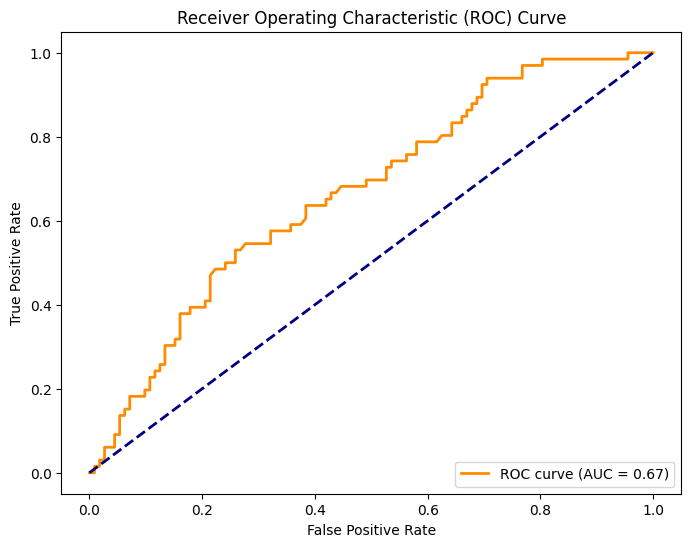

In [21]:
plot_roc_curve(best_estimator, X_test, y_test)

## GradientBoosting

In [22]:
model = GradientBoostingClassifier()
model.fit(X_train, y_train)


GradientBoostingClassifier()

In [23]:
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

y_pred = model.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('AUROC:', roc_auc_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Predict on the train data
y_train_pred = model.predict(X_train)
print('Train Accuracy:', accuracy_score(y_train, y_train_pred))
print('Train AUROC:', roc_auc_score(y_train, y_train_pred))
print('Train Classification Report:\n', classification_report(y_train, y_train_pred))

Accuracy: 0.6460674157303371
AUROC: 0.581845238095238
              precision    recall  f1-score   support

           0       0.68      0.83      0.75       112
           1       0.54      0.33      0.41        66

    accuracy                           0.65       178
   macro avg       0.61      0.58      0.58       178
weighted avg       0.63      0.65      0.62       178

Train Accuracy: 0.8928571428571429
Train AUROC: 0.8653148248956631
Train Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.97      0.92       334
           1       0.94      0.76      0.84       198

    accuracy                           0.89       532
   macro avg       0.91      0.87      0.88       532
weighted avg       0.90      0.89      0.89       532



In [24]:
model_configs = {
    'random_state':51,
}
# model params
model_params = {
    'max_depth': [2, 5, 15, 20],
    'min_samples_leaf': [2, 25, 50],
}
# search parameters
serch_params = {
    'scoring': 'roc_auc',
    'return_train_score':True,
    'n_jobs':-1,
}

# runs random search
reg = GridSearchCV(GradientBoostingClassifier(**model_configs),
                         model_params, **serch_params)
search = reg.fit(X_train, y_train)

Best score = 0.6437997947326306
Best params = {'max_depth': 2, 'min_samples_leaf': 2}
Accuracy: 0.6741573033707865
Balanced Accuracy: 0.619724025974026
AUROC: 0.6580762987012987
              precision    recall  f1-score   support

           0       0.70      0.83      0.76       112
           1       0.59      0.41      0.48        66

    accuracy                           0.67       178
   macro avg       0.65      0.62      0.62       178
weighted avg       0.66      0.67      0.66       178

Validation ROC AUC Scores (Mean per Param Combination): [0.64379979 0.63567999 0.63013299 0.62397288 0.61851573 0.62004601
 0.60956128 0.61566451 0.61785035 0.60484301 0.61566451 0.61785035]
Validation ROC AUC Std Dev: [0.03586206 0.01322298 0.0078511  0.04392118 0.01533666 0.01705972
 0.06015292 0.01700165 0.00994064 0.05279913 0.01700165 0.00994064]
Train Accuracy: 0.7969924812030075
Train Balanced Accuracy: 0.7509223976289845
Train AUROC: 0.881245085586403
Train Classification Report:
  

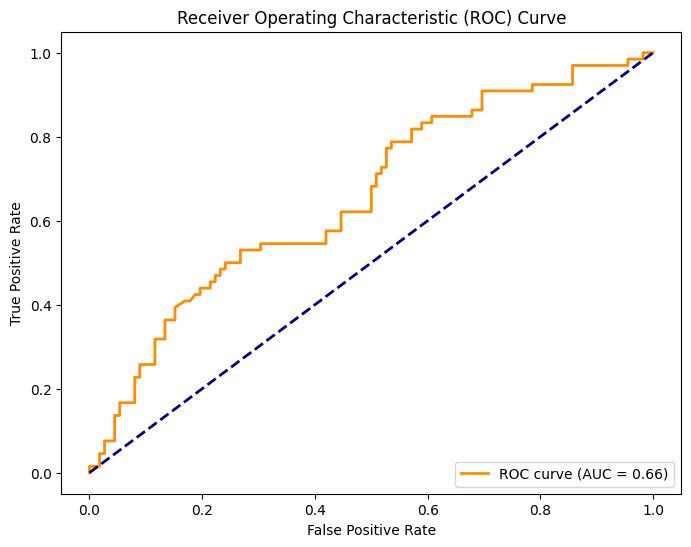

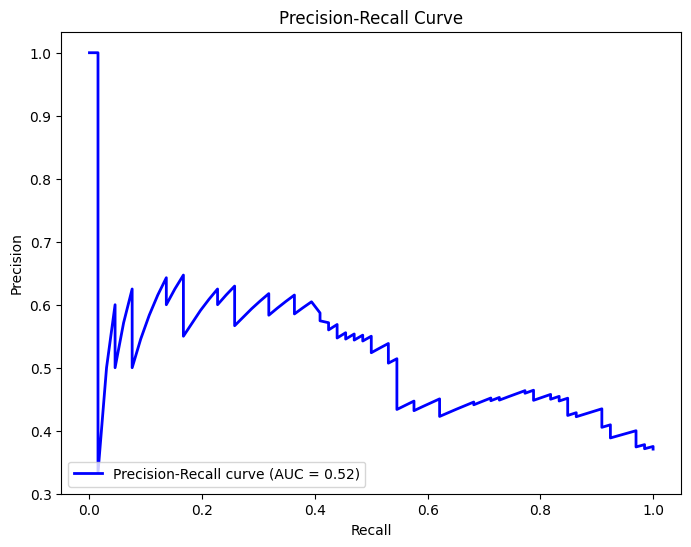

In [25]:
from sklearn.metrics import precision_recall_curve, auc, balanced_accuracy_score

# results
best_estimator = search.best_estimator_
print(f"Best score = {search.best_score_}")
print(f"Best params = {search.best_params_}")
# save best params
rf_best_params =  {**model_configs, **search.best_params_}

y_pred = best_estimator.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Balanced Accuracy:', balanced_accuracy_score(y_test, y_pred))
print('AUROC:', roc_auc_score(y_test, best_estimator.predict_proba(X_test)[:,1]))
print(classification_report(y_test, y_pred))

cv_results = search.cv_results_
val_roc_auc_scores = cv_results['mean_test_score']
val_roc_auc_std = cv_results['std_test_score']
print("Validation ROC AUC Scores (Mean per Param Combination):", val_roc_auc_scores)
print("Validation ROC AUC Std Dev:", val_roc_auc_std)

# Predict on the train data
y_train_pred = best_estimator.predict(X_train)
print('Train Accuracy:', accuracy_score(y_train, y_train_pred))
print('Train Balanced Accuracy:', balanced_accuracy_score(y_train, y_train_pred))
print('Train AUROC:', roc_auc_score(y_train, best_estimator.predict_proba(X_train)[:,1]))
print('Train Classification Report:\n', classification_report(y_train, y_train_pred))

plot_roc_curve(best_estimator, X_test, y_test)

# Plot Precision-Recall curve
y_prob = best_estimator.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_prob)
pr_auc = auc(recall, precision)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='b', lw=2, label=f"Precision-Recall curve (AUC = {pr_auc:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="lower left")
plt.show()

In [26]:
# Get ROC AUC scores for each validation split
folds = [key for key in cv_results.keys() if key.startswith('split') and key.endswith('_test_score')]
fold_scores = {fold: cv_results[fold] for fold in folds}

for fold, scores in fold_scores.items():
    print(f"{fold}: {scores}")

split0_test_score: [0.69925373 0.62761194 0.63432836 0.66940299 0.60186567 0.65
 0.64552239 0.61455224 0.62425373 0.61716418 0.61455224 0.62425373]
split1_test_score: [0.64179104 0.625      0.62089552 0.63992537 0.61716418 0.60783582
 0.64962687 0.60746269 0.60970149 0.64664179 0.60746269 0.60970149]
split2_test_score: [0.66054344 0.66016073 0.63758132 0.63834673 0.62303865 0.61921163
 0.54305396 0.59586682 0.60658247 0.56869499 0.59586682 0.60658247]
split3_test_score: [0.5912744  0.63911213 0.62035974 0.53999235 0.60543437 0.60007654
 0.5315729  0.61347111 0.61500191 0.52315346 0.61347111 0.61500191]
split4_test_score: [0.62613636 0.62651515 0.6375     0.63219697 0.64507576 0.62310606
 0.6780303  0.6469697  0.63371212 0.66856061 0.6469697  0.63371212]


In [27]:
from sklearn.metrics import balanced_accuracy_score, accuracy_score

thresholds = [0.1,0.2,0.25,0.3, 0.35, 0.4, 0.45, 0.5, 0.6, 0.7]
y_probs = best_estimator.predict_proba(X_test)[:, 1]

for threshold in thresholds:
    y_pred = (y_probs >= threshold).astype(int)
    acc = accuracy_score(y_test, y_pred)
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    print(f"Threshold: {threshold}, Accuracy: {acc}, Balanced Accuracy: {bal_acc}")

Threshold: 0.1, Accuracy: 0.37640449438202245, Balanced Accuracy: 0.5013528138528138
Threshold: 0.2, Accuracy: 0.46629213483146065, Balanced Accuracy: 0.5603354978354979
Threshold: 0.25, Accuracy: 0.5168539325842697, Balanced Accuracy: 0.5911796536796536
Threshold: 0.3, Accuracy: 0.5842696629213483, Balanced Accuracy: 0.626082251082251
Threshold: 0.35, Accuracy: 0.5674157303370787, Balanced Accuracy: 0.5691287878787878
Threshold: 0.4, Accuracy: 0.6404494382022472, Balanced Accuracy: 0.6209415584415584
Threshold: 0.45, Accuracy: 0.6573033707865169, Balanced Accuracy: 0.625
Threshold: 0.5, Accuracy: 0.6741573033707865, Balanced Accuracy: 0.619724025974026
Threshold: 0.6, Accuracy: 0.6404494382022472, Balanced Accuracy: 0.5431547619047619
Threshold: 0.7, Accuracy: 0.6404494382022472, Balanced Accuracy: 0.5307088744588745


## SVC

In [28]:
from sklearn.svm import SVC

# Initialize the SVM model with a linear kernel
svm_model = SVC(C= 0.05, degree = 1, gamma= 'scale',kernel='linear', random_state=42)

# Train the model on the training data
svm_model.fit(X_train, y_train)

SVC(C=0.05, degree=1, kernel='linear', random_state=42)

In [29]:
# Predict on the test data
y_pred = svm_model.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('AUROC:', roc_auc_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


# Predict on the train data
y_train_pred = model.predict(X_train)
print('Train Accuracy:', accuracy_score(y_train, y_train_pred))
print('Train AUROC:', roc_auc_score(y_train, y_train_pred))
print('Train Classification Report:\n', classification_report(y_train, y_train_pred))

Accuracy: 0.6573033707865169
AUROC: 0.5907738095238095
              precision    recall  f1-score   support

           0       0.68      0.85      0.76       112
           1       0.56      0.33      0.42        66

    accuracy                           0.66       178
   macro avg       0.62      0.59      0.59       178
weighted avg       0.64      0.66      0.63       178

Train Accuracy: 0.8928571428571429
Train AUROC: 0.8653148248956631
Train Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.97      0.92       334
           1       0.94      0.76      0.84       198

    accuracy                           0.89       532
   macro avg       0.91      0.87      0.88       532
weighted avg       0.90      0.89      0.89       532



In [30]:
param_grid = {
    'C': [0.1,0.2,0.3,0.4,0.5, 1.],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto', 0.1, 1,10],
    'degree': [1,2, 3, 4],
}

# Initialize GridSearchCV
grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=10)

# Fit the grid search
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
[CV 1/5; 1/240] START C=0.1, degree=1, gamma=scale, kernel=linear...............
[CV 2/5; 1/240] START C=0.1, degree=1, gamma=scale, kernel=linear...............[CV 3/5; 1/240] START C=0.1, degree=1, gamma=scale, kernel=linear...............

[CV 4/5; 1/240] START C=0.1, degree=1, gamma=scale, kernel=linear...............
[CV 5/5; 1/240] START C=0.1, degree=1, gamma=scale, kernel=linear...............
[CV 1/5; 2/240] START C=0.1, degree=1, gamma=scale, kernel=rbf..................
[CV 2/5; 2/240] START C=0.1, degree=1, gamma=scale, kernel=rbf..................
[CV 3/5; 2/240] START C=0.1, degree=1, gamma=scale, kernel=rbf..................
[CV 4/5; 2/240] START C=0.1, degree=1, gamma=scale, kernel=rbf..................
[CV 5/5; 2/240] START C=0.1, degree=1, gamma=scale, kernel=rbf..................
[CV 1/5; 3/240] START C=0.1, degree=1, gamma=auto, kernel=linear................
[CV 2/5; 3/240] START C=0.1, degree=1, gamma=

GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 0.2, 0.3, 0.4, 0.5, 1.0],
                         'degree': [1, 2, 3, 4],
                         'gamma': ['scale', 'auto', 0.1, 1, 10],
                         'kernel': ['linear', 'rbf']},
             scoring='roc_auc', verbose=10)

Best params = {'C': 0.1, 'degree': 1, 'gamma': 'scale', 'kernel': 'linear'}
Accuracy: 0.6573033707865169
AUROC: 0.5907738095238095
              precision    recall  f1-score   support

           0       0.68      0.85      0.76       112
           1       0.56      0.33      0.42        66

    accuracy                           0.66       178
   macro avg       0.62      0.59      0.59       178
weighted avg       0.64      0.66      0.63       178

Train Accuracy: 0.8928571428571429
Train AUROC: 0.8653148248956631
Train Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.97      0.92       334
           1       0.94      0.76      0.84       198

    accuracy                           0.89       532
   macro avg       0.91      0.87      0.88       532
weighted avg       0.90      0.89      0.89       532



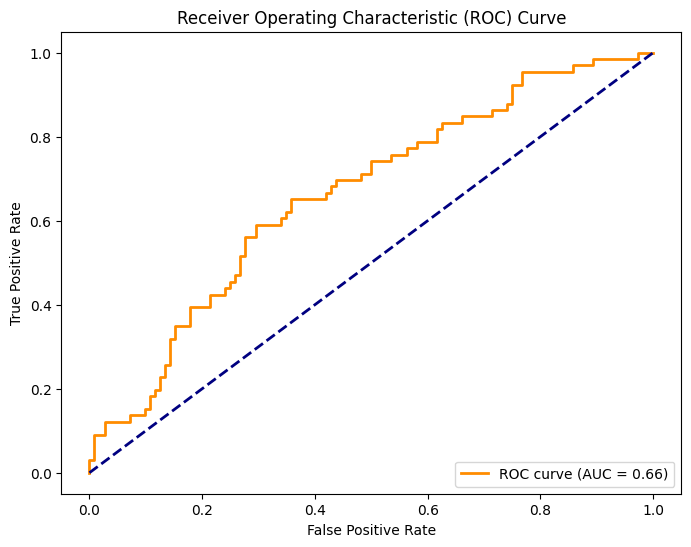

In [31]:
best_estimator = grid_search.best_estimator_
print(f"Best params = {grid_search.best_params_}")
y_pred = best_estimator.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('AUROC:', roc_auc_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


y_train_pred = model.predict(X_train)
print('Train Accuracy:', accuracy_score(y_train, y_train_pred))
print('Train AUROC:', roc_auc_score(y_train, y_train_pred))
print('Train Classification Report:\n', classification_report(y_train, y_train_pred))

# Get predicted probabilities for the positive class
y_prob = best_estimator.decision_function(X_test)  # Use decision_function for SVM

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line for random guessing
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

In [32]:
from sklearn.model_selection import RandomizedSearchCV


# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=SVC(), param_distributions=param_grid, 
                                   n_iter=100, cv=5, scoring='roc_auc', n_jobs=-1, random_state=42)

# Fit the random search
random_search.fit(X_train, y_train)

# Results
best_estimator = random_search.best_estimator_
print(f"Best params = {random_search.best_params_}")

# Predict on the test data
y_pred = best_estimator.predict(X_test)
print('Test Accuracy:', accuracy_score(y_test, y_pred))
print('Test AUROC:', roc_auc_score(y_test, y_pred))
print('Test Classification Report:\n', classification_report(y_test, y_pred))


# Predict on the train data
y_train_pred = best_estimator.predict(X_train)
print('Train Accuracy:', accuracy_score(y_train, y_train_pred))
print('Train AUROC:', roc_auc_score(y_train, y_train_pred))
print('Train Classification Report:\n', classification_report(y_train, y_train_pred))

Best params = {'kernel': 'linear', 'gamma': 0.1, 'degree': 3, 'C': 0.1}
Test Accuracy: 0.6573033707865169
Test AUROC: 0.5907738095238095
Test Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.85      0.76       112
           1       0.56      0.33      0.42        66

    accuracy                           0.66       178
   macro avg       0.62      0.59      0.59       178
weighted avg       0.64      0.66      0.63       178

Train Accuracy: 0.6616541353383458
Train AUROC: 0.5752736950341741
Train Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.91      0.77       334
           1       0.62      0.24      0.34       198

    accuracy                           0.66       532
   macro avg       0.64      0.58      0.56       532
weighted avg       0.65      0.66      0.61       532



## Logistic Regression

In [33]:
from sklearn.linear_model import LogisticRegression

In [34]:
log_reg = LogisticRegression(max_iter=1000)
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],  # L1 for Lasso, L2 for Ridge # 'liblinear' is a good choice for small datasets
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid, 
                           cv=5, n_jobs=-1, scoring='roc_auc')
grid_search.fit(X_train, y_train)

# Get the best estimator
best_estimator = grid_search.best_estimator_
print(f"Best params = {grid_search.best_params_}")

# Make predictions
y_pred = best_estimator.predict(X_test)

# Evaluate the mode

/home/hep/lprate/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/hep/lprate/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

Best params = {'C': 0.01, 'penalty': 'l2'}


/home/hep/lprate/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.6573033707865169
AUROC: 0.6001082251082251
              precision    recall  f1-score   support

           0       0.69      0.82      0.75       112
           1       0.56      0.38      0.45        66

    accuracy                           0.66       178
   macro avg       0.62      0.60      0.60       178
weighted avg       0.64      0.66      0.64       178

Train Accuracy: 0.8928571428571429
Train AUROC: 0.8653148248956631
Train Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.97      0.92       334
           1       0.94      0.76      0.84       198

    accuracy                           0.89       532
   macro avg       0.91      0.87      0.88       532
weighted avg       0.90      0.89      0.89       532



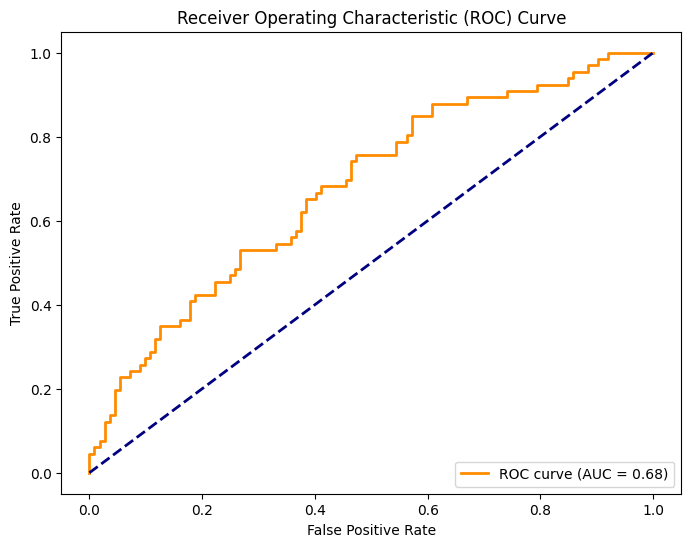

In [35]:
print('Accuracy:', accuracy_score(y_test, y_pred))
print('AUROC:', roc_auc_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


# Predict on the train data
y_train_pred = model.predict(X_train)
print('Train Accuracy:', accuracy_score(y_train, y_train_pred))
print('Train AUROC:', roc_auc_score(y_train, y_train_pred))
print('Train Classification Report:\n', classification_report(y_train, y_train_pred))

plot_roc_curve(best_estimator, X_test, y_test)

# XGBOOST

In [36]:
from xgboost import XGBClassifier
param_grid = {
    'learning_rate': [0.01, 0.1],     # Smaller steps for better generalization
    'n_estimators': [50, 100, 150],         # Fewer trees for small data
    'max_depth': [3,  5],                 # Shallow trees to limit complexity
    'min_child_weight': [1, 3, 5],          # Regularize leaf nodes (higher = more conservative)
    'gamma': [0, 0.1, 0.2],                 # Minimum loss reduction to split a node
    'subsample': [0.7, 0.8, 1.0],           # Randomly sample rows per tree (prevents overfitting)
    'colsample_bytree': [0.7, 0.8, 1.0],    # Randomly sample columns per tree
    'reg_alpha': [0, 0.1, 1],               # L1 regularization (sparsity)
    'reg_lambda': [0, 0.1, 1],              # L2 regularization (smooth weights)
    'scale_pos_weight': [1, (len(y_train)-sum(y_train))/sum(y_train)]     # Handle class imbalance (use if minority class is rare)
}


# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=XGBClassifier(random_state=42), param_grid=param_grid, 
                           cv=5, n_jobs=-1, scoring='balanced_accuracy')
grid_search.fit(X_train, y_train)

# Get the best estimator
best_estimator = grid_search.best_estimator_
print(f"Best params = {grid_search.best_params_}")

# Make predictions
y_pred = best_estimator.predict_proba(X_test)[:,1]

Best params = {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 0, 'scale_pos_weight': 1.6868686868686869, 'subsample': 1.0}


Best score = 0.6437997947326306
Best params = {'max_depth': 2, 'min_samples_leaf': 2}
Accuracy: 0.6741573033707865
Balanced Accuracy: 0.619724025974026
AUROC: 0.6580762987012987
              precision    recall  f1-score   support

           0       0.70      0.83      0.76       112
           1       0.59      0.41      0.48        66

    accuracy                           0.67       178
   macro avg       0.65      0.62      0.62       178
weighted avg       0.66      0.67      0.66       178

Validation ROC AUC Scores (Mean per Param Combination): [0.64379979 0.63567999 0.63013299 0.62397288 0.61851573 0.62004601
 0.60956128 0.61566451 0.61785035 0.60484301 0.61566451 0.61785035]
Validation ROC AUC Std Dev: [0.03586206 0.01322298 0.0078511  0.04392118 0.01533666 0.01705972
 0.06015292 0.01700165 0.00994064 0.05279913 0.01700165 0.00994064]
Train Accuracy: 0.7969924812030075
Train Balanced Accuracy: 0.7509223976289845
Train AUROC: 0.881245085586403
Train Classification Report:
  

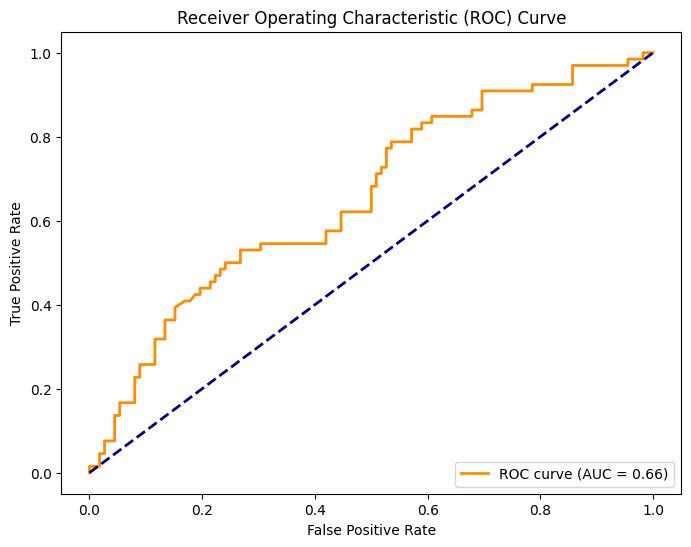

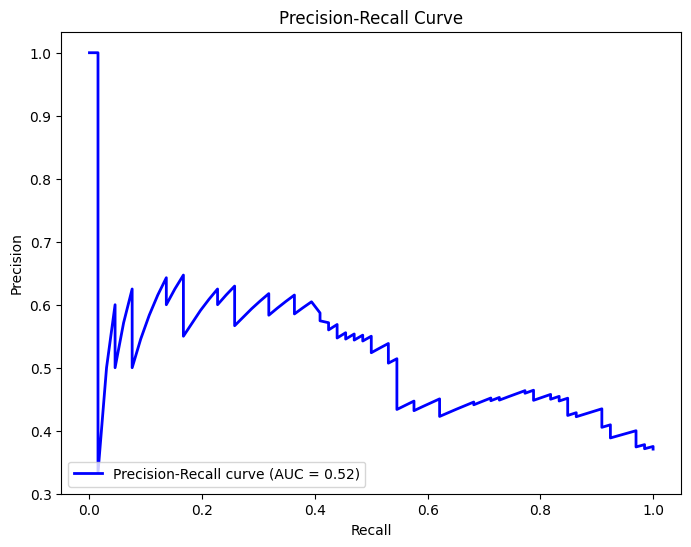

In [37]:

best_estimator = search.best_estimator_
print(f"Best score = {search.best_score_}")
print(f"Best params = {search.best_params_}")
# save best params
rf_best_params =  {**model_configs, **search.best_params_}

y_pred = best_estimator.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred>0.5))
print('Balanced Accuracy:', balanced_accuracy_score(y_test, y_pred>0.5))
print('AUROC:', roc_auc_score(y_test, best_estimator.predict_proba(X_test)[:,1]))
print(classification_report(y_test, y_pred))

cv_results = search.cv_results_
val_roc_auc_scores = cv_results['mean_test_score']
val_roc_auc_std = cv_results['std_test_score']
print("Validation ROC AUC Scores (Mean per Param Combination):", val_roc_auc_scores)
print("Validation ROC AUC Std Dev:", val_roc_auc_std)

# Predict on the train data
y_train_pred = best_estimator.predict(X_train)
print('Train Accuracy:', accuracy_score(y_train, y_train_pred))
print('Train Balanced Accuracy:', balanced_accuracy_score(y_train, y_train_pred))
print('Train AUROC:', roc_auc_score(y_train, best_estimator.predict_proba(X_train)[:,1]))
print('Train Classification Report:\n', classification_report(y_train, y_train_pred))

plot_roc_curve(best_estimator, X_test, y_test)

# Plot Precision-Recall curve
y_prob = best_estimator.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_prob)
pr_auc = auc(recall, precision)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='b', lw=2, label=f"Precision-Recall curve (AUC = {pr_auc:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="lower left")
plt.show()